In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, LSTM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 데이터 불러오기

In [5]:
df = pd.read_csv("./data/feature_df.ver2.csv")

In [6]:
df.head()

,SO2_incheon_0,CO_incheon_0,O3_incheon_0,NO2_incheon_0,PM10_incheon_0,datetime,SO2_incheon_1,CO_incheon_1,O3_incheon_1,NO2_incheon_1,...,3h_3,3h_4,3h_5,3h_6,3h_7,3h_8,quarter_1,quarter_2,quarter_3,quarter_4
0,0.007,0.2,0.015,0.004,73.0,2015-01-01 00:00:00,0.0027,0.2,0.026,0.0024,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.007,0.2,0.015,0.005,93.0,2015-01-01 01:00:00,0.0029,0.2,0.025,0.0023,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.007,0.1,0.015,0.004,100.0,2015-01-01 02:00:00,0.0030,0.2,0.024,0.0025,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.006,0.1,0.014,0.004,111.0,2015-01-01 03:00:00,0.0027,0.2,0.024,0.0022,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.007,0.1,0.014,0.004,131.0,2015-01-01 04:00:00,0.0021,0.2,0.024,0.0020,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [7]:
df.shape

(67176, 953)

In [8]:
x = df.drop(["datetime", "PM10_y_bin"], axis = 1)
y = df["PM10_y_bin"]

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 8)

# MinMax Scaler

In [10]:
mm = MinMaxScaler()

In [11]:
scaled_train = mm.fit_transform(x_train)
scaled_test = mm.transform(x_test)

In [12]:
scaled_train.shape, scaled_test.shape

((40305, 951), (26871, 951))

In [13]:
scaled_train = scaled_train.reshape(-1, 951, 1)
scaled_test = scaled_test.reshape(-1, 951, 1)

In [14]:
def score(y_test, y_pred) :
    y_pred = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average = "weighted")
    recall = recall_score(y_test, y_pred, average = 'weighted')
    precision = precision_score(y_test, y_pred, average = 'weighted')
    return print("accuracy_score : ", accuracy, "\nf1_score : ", f1, "\nrecall_score :", recall, "\nprecision_score : ", precision)

# Model1

In [13]:
model = Sequential()
model.add(Conv1D(filters = 64, kernel_size = 3, activation = "relu", padding = "same", input_shape = (951, 1)))
model.add(keras.layers.MaxPooling1D(3))
model.add(Dropout(0.3))
model.add(Conv1D(filters = 64, kernel_size = 3, activation = "relu", padding = "same"))
model.add(keras.layers.MaxPooling1D(3))
model.add(Dropout(0.3))
model.add(keras.layers.Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(4, activation = "softmax"))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 951, 64)           256       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 317, 64)          0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 317, 64)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 317, 64)           12352     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 105, 64)          0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 105, 64)          

In [16]:
adam = keras.optimizers.Adam(learning_rate = 0.0001)
checkpoint = keras.callbacks.ModelCheckpoint("./model/classifier_best_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = adam, metrics = "accuracy")
history = model.fit(scaled_train, y_train, epochs = 1000, validation_split = 0.2, batch_size = 64, 
                    callbacks = [early_stopping_cb, checkpoint])

Epoch 1/1000
504/504 [==============================] - 50s 98ms/step - loss: 0.8256 - accuracy: 0.6354 - val_loss: 0.7640 - val_accuracy: 0.6540
Epoch 2/1000
504/504 [==============================] - 48s 94ms/step - loss: 0.7891 - accuracy: 0.6564 - val_loss: 0.7465 - val_accuracy: 0.6612
Epoch 3/1000
504/504 [==============================] - 48s 95ms/step - loss: 0.7717 - accuracy: 0.6615 - val_loss: 0.7401 - val_accuracy: 0.6610
Epoch 4/1000
504/504 [==============================] - 46s 91ms/step - loss: 0.7586 - accuracy: 0.6687 - val_loss: 0.7310 - val_accuracy: 0.6644
Epoch 5/1000
504/504 [==============================] - 46s 91ms/step - loss: 0.7498 - accuracy: 0.6710 - val_loss: 0.7220 - val_accuracy: 0.6669
Epoch 6/1000
504/504 [==============================] - 49s 98ms/step - loss: 0.7397 - accuracy: 0.6754 - val_loss: 0.7186 - val_accuracy: 0.6726
Epoch 7/1000
504/504 [==============================] - 47s 94ms/step - loss: 0.7348 - accuracy: 0.6785 - val_loss: 0.7151 -

Epoch 57/1000
504/504 [==============================] - 46s 92ms/step - loss: 0.6187 - accuracy: 0.7251 - val_loss: 0.6391 - val_accuracy: 0.7121
Epoch 58/1000
504/504 [==============================] - 46s 92ms/step - loss: 0.6165 - accuracy: 0.7268 - val_loss: 0.6404 - val_accuracy: 0.7115
Epoch 59/1000
504/504 [==============================] - 46s 91ms/step - loss: 0.6147 - accuracy: 0.7278 - val_loss: 0.6407 - val_accuracy: 0.7138
Epoch 60/1000
504/504 [==============================] - 46s 91ms/step - loss: 0.6149 - accuracy: 0.7286 - val_loss: 0.6365 - val_accuracy: 0.7162
Epoch 61/1000
504/504 [==============================] - 46s 91ms/step - loss: 0.6096 - accuracy: 0.7302 - val_loss: 0.6381 - val_accuracy: 0.7116
Epoch 62/1000
504/504 [==============================] - 46s 91ms/step - loss: 0.6122 - accuracy: 0.7302 - val_loss: 0.6373 - val_accuracy: 0.7152
Epoch 63/1000
504/504 [==============================] - 46s 91ms/step - loss: 0.6083 - accuracy: 0.7292 - val_loss: 0

504/504 [==============================] - 46s 91ms/step - loss: 0.4128 - accuracy: 0.8217 - val_loss: 0.5772 - val_accuracy: 0.7570
Epoch 168/1000
504/504 [==============================] - 46s 91ms/step - loss: 0.4083 - accuracy: 0.8220 - val_loss: 0.5729 - val_accuracy: 0.7626
Epoch 169/1000
504/504 [==============================] - 46s 91ms/step - loss: 0.4067 - accuracy: 0.8237 - val_loss: 0.5770 - val_accuracy: 0.7631


In [17]:
model.evaluate(scaled_test, y_test)

840/840 [==============================] - 8s 9ms/step - loss: 0.5596 - accuracy: 0.7645


[0.5595524907112122, 0.7645416855812073]

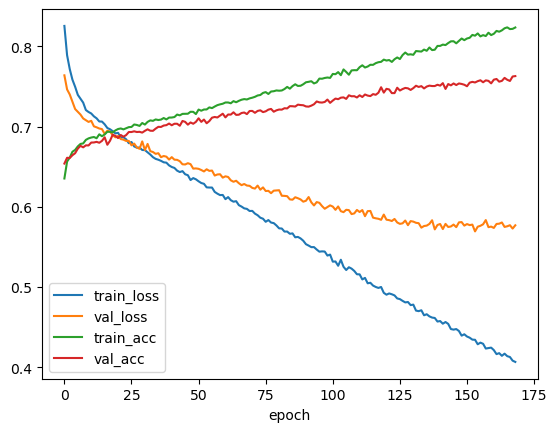

In [18]:
plt.figure()
plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.xlabel("epoch")
plt.legend()
plt.show()

In [19]:
y_pred = model.predict(scaled_test)

840/840 [==============================] - 8s 9ms/step


In [20]:
score(y_test, y_pred)

accuracy_score :  0.7645416992296528 
f1_score :  0.7606465439631609 
recall_score : 0.7645416992296528 
precision_score :  0.7620523632947234


# Model2

- epoch : 25

In [35]:
model2 = Sequential()
model2.add(Conv1D(filters = 64, kernel_size = 3, activation = "relu", padding = "same", input_shape = (951, 1)))
model2.add(keras.layers.MaxPooling1D(3))
model2.add(Dropout(0.3))
model2.add(Conv1D(filters = 64, kernel_size = 3, activation = "relu", padding = "same"))
model2.add(keras.layers.MaxPooling1D(3))
model2.add(Dropout(0.3))
model2.add(keras.layers.Flatten())
model2.add(Dense(64, activation = "relu"))
model2.add(Dense(32, activation = "relu"))
model2.add(Dropout(0.3))
model2.add(Dense(4, activation = "softmax"))

In [36]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 951, 64)           256       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 317, 64)          0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 317, 64)           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 317, 64)           12352     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 105, 64)          0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 105, 64)          

In [37]:
adam = keras.optimizers.Adam(learning_rate = 0.0001)
checkpoint = keras.callbacks.ModelCheckpoint("./model/classifier_best_model2.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True)
model2.compile(loss = "sparse_categorical_crossentropy", optimizer = adam, metrics = "accuracy")
history2 = model2.fit(scaled_train, y_train, epochs = 25, validation_split = 0.2, batch_size = 64, 
                    callbacks = [early_stopping_cb, checkpoint])

Epoch 1/25
504/504 [==============================] - 52s 102ms/step - loss: 0.8804 - accuracy: 0.6007 - val_loss: 0.7860 - val_accuracy: 0.6549
Epoch 2/25
504/504 [==============================] - 50s 98ms/step - loss: 0.8030 - accuracy: 0.6454 - val_loss: 0.7521 - val_accuracy: 0.6626
Epoch 3/25
504/504 [==============================] - 50s 99ms/step - loss: 0.7816 - accuracy: 0.6599 - val_loss: 0.7435 - val_accuracy: 0.6695
Epoch 4/25
504/504 [==============================] - 49s 98ms/step - loss: 0.7700 - accuracy: 0.6633 - val_loss: 0.7329 - val_accuracy: 0.6726
Epoch 5/25
504/504 [==============================] - 49s 98ms/step - loss: 0.7590 - accuracy: 0.6708 - val_loss: 0.7247 - val_accuracy: 0.6725
Epoch 6/25
504/504 [==============================] - 49s 98ms/step - loss: 0.7519 - accuracy: 0.6724 - val_loss: 0.7230 - val_accuracy: 0.6739
Epoch 7/25
504/504 [==============================] - 50s 98ms/step - loss: 0.7490 - accuracy: 0.6737 - val_loss: 0.7271 - val_accuracy

In [38]:
model2.evaluate(scaled_test, y_test)

840/840 [==============================] - 8s 10ms/step - loss: 0.6730 - accuracy: 0.7009


[0.6729838848114014, 0.7009043097496033]

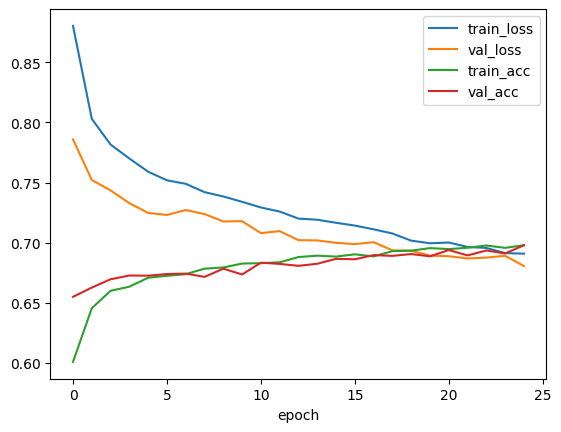

In [39]:
plt.figure()
plt.plot(history2.history["loss"], label = "train_loss")
plt.plot(history2.history["val_loss"], label = "val_loss")
plt.plot(history2.history["accuracy"], label = "train_acc")
plt.plot(history2.history["val_accuracy"], label = "val_acc")

plt.xlabel("epoch")
plt.legend()
plt.show()

In [40]:
y_pred2 = model2.predict(scaled_test)

840/840 [==============================] - 8s 10ms/step


In [41]:
score(y_test, y_pred2)

accuracy_score :  0.7009043206430725 
f1_score :  0.6785519198940153 
recall_score : 0.7009043206430725 
precision_score :  0.6844115272780595


C:\ProgramData\Anaconda3\envs\data\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model3

- Dense 층 하나 제거

In [31]:
model3 = Sequential()
model3.add(Conv1D(filters = 64, kernel_size = 3, activation = "relu", padding = "same", input_shape = (951, 1)))
model3.add(keras.layers.MaxPooling1D(3))
model3.add(Dropout(0.3))
model3.add(Conv1D(filters = 64, kernel_size = 3, activation = "relu", padding = "same"))
model3.add(keras.layers.MaxPooling1D(3))
model3.add(Dropout(0.3))
model3.add(keras.layers.Flatten())
model3.add(Dense(64, activation = "relu"))
model3.add(Dropout(0.3))
model3.add(Dense(4, activation = "softmax"))

In [33]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 951, 64)           256       
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 317, 64)          0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 317, 64)           0         
                                                                 
 conv1d_11 (Conv1D)          (None, 317, 64)           12352     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 105, 64)          0         
 g1D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 105, 64)          

In [34]:
adam = keras.optimizers.Adam(learning_rate = 0.0001)
checkpoint = keras.callbacks.ModelCheckpoint("./model/classifier_best_model3.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True)
model3.compile(loss = "sparse_categorical_crossentropy", optimizer = adam, metrics = "accuracy")
history3 = model3.fit(scaled_train, y_train, epochs = 1000, validation_split = 0.2, batch_size = 64, 
                    callbacks = [early_stopping_cb, checkpoint])

Epoch 1/1000
504/504 [==============================] - 45s 89ms/step - loss: 0.8455 - accuracy: 0.6202 - val_loss: 0.7792 - val_accuracy: 0.6600
Epoch 2/1000
504/504 [==============================] - 43s 86ms/step - loss: 0.7725 - accuracy: 0.6589 - val_loss: 0.7514 - val_accuracy: 0.6629
Epoch 3/1000
504/504 [==============================] - 44s 86ms/step - loss: 0.7559 - accuracy: 0.6692 - val_loss: 0.7425 - val_accuracy: 0.6626
Epoch 4/1000
504/504 [==============================] - 43s 86ms/step - loss: 0.7435 - accuracy: 0.6716 - val_loss: 0.7328 - val_accuracy: 0.6685
Epoch 5/1000
504/504 [==============================] - 43s 86ms/step - loss: 0.7377 - accuracy: 0.6760 - val_loss: 0.7331 - val_accuracy: 0.6654
Epoch 6/1000
504/504 [==============================] - 44s 87ms/step - loss: 0.7317 - accuracy: 0.6753 - val_loss: 0.7229 - val_accuracy: 0.6740
Epoch 7/1000
504/504 [==============================] - 44s 87ms/step - loss: 0.7269 - accuracy: 0.6802 - val_loss: 0.7188 -

Epoch 57/1000
504/504 [==============================] - 45s 89ms/step - loss: 0.6257 - accuracy: 0.7223 - val_loss: 0.6482 - val_accuracy: 0.7070
Epoch 58/1000
504/504 [==============================] - 48s 95ms/step - loss: 0.6225 - accuracy: 0.7233 - val_loss: 0.6435 - val_accuracy: 0.7082
Epoch 59/1000
504/504 [==============================] - 46s 92ms/step - loss: 0.6215 - accuracy: 0.7232 - val_loss: 0.6442 - val_accuracy: 0.7080
Epoch 60/1000
504/504 [==============================] - 48s 96ms/step - loss: 0.6211 - accuracy: 0.7228 - val_loss: 0.6428 - val_accuracy: 0.7072
Epoch 61/1000
504/504 [==============================] - 48s 95ms/step - loss: 0.6225 - accuracy: 0.7213 - val_loss: 0.6436 - val_accuracy: 0.7077
Epoch 62/1000
504/504 [==============================] - 49s 96ms/step - loss: 0.6166 - accuracy: 0.7255 - val_loss: 0.6408 - val_accuracy: 0.7086
Epoch 63/1000
504/504 [==============================] - 48s 95ms/step - loss: 0.6167 - accuracy: 0.7280 - val_loss: 0

504/504 [==============================] - 41s 81ms/step - loss: 0.4624 - accuracy: 0.7965 - val_loss: 0.5716 - val_accuracy: 0.7595
Epoch 168/1000
504/504 [==============================] - 41s 81ms/step - loss: 0.4622 - accuracy: 0.7958 - val_loss: 0.5734 - val_accuracy: 0.7557
Epoch 169/1000
504/504 [==============================] - 41s 81ms/step - loss: 0.4635 - accuracy: 0.7962 - val_loss: 0.5715 - val_accuracy: 0.7576
Epoch 170/1000
504/504 [==============================] - 41s 81ms/step - loss: 0.4624 - accuracy: 0.7953 - val_loss: 0.5740 - val_accuracy: 0.7564
Epoch 171/1000
504/504 [==============================] - 41s 81ms/step - loss: 0.4580 - accuracy: 0.7995 - val_loss: 0.5783 - val_accuracy: 0.7571
Epoch 172/1000
504/504 [==============================] - 41s 81ms/step - loss: 0.4588 - accuracy: 0.7975 - val_loss: 0.5750 - val_accuracy: 0.7583
Epoch 173/1000
504/504 [==============================] - 41s 82ms/step - loss: 0.4561 - accuracy: 0.7987 - val_loss: 0.5688 - 

In [35]:
model3.evaluate(scaled_test, y_test)

840/840 [==============================] - 7s 8ms/step - loss: 0.5459 - accuracy: 0.7711


[0.5458884239196777, 0.7711287140846252]

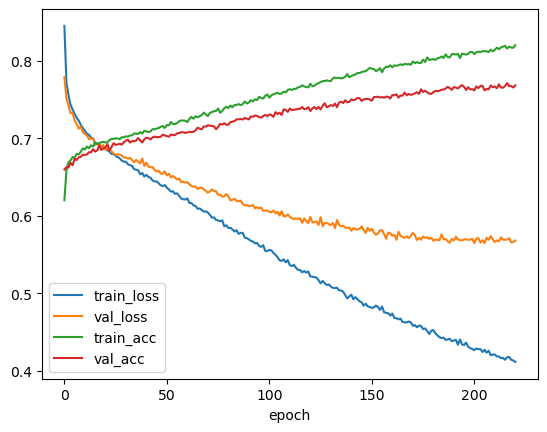

In [36]:
plt.figure()
plt.plot(history3.history["loss"], label = "train_loss")
plt.plot(history3.history["val_loss"], label = "val_loss")
plt.plot(history3.history["accuracy"], label = "train_acc")
plt.plot(history3.history["val_accuracy"], label = "val_acc")

plt.xlabel("epoch")
plt.legend()
plt.show()

In [37]:
y_pred3 = model3.predict(scaled_test)

840/840 [==============================] - 7s 8ms/step


In [38]:
score(y_test, y_pred3)

accuracy_score :  0.771128726135983 
f1_score :  0.7681809073613672 
recall_score : 0.771128726135983 
precision_score :  0.7711646869777826


# Model4

- epoch를 줄여서 500으로 사용


- optimizer = Adam (learning_rate = 0.0001)
- loss = "mse"
- epochs = 500, batch_size = 64
- kernel_size = 3


- Conv1D(64)
- MaxPool1D(3)
- Dropout(0.3)
- Conv1D(64)
- MaxPool1D(3)
- Dropout(0.3)
- Dense(64)
- Dense(32)
- Dropout(0.3)

In [21]:
model4 = Sequential()
model4.add(Conv1D(filters = 64, kernel_size = 3, activation = "relu", padding = "same", input_shape = (951, 1)))
model4.add(keras.layers.MaxPooling1D(3))
model4.add(Dropout(0.3))
model4.add(Conv1D(filters = 64, kernel_size = 3, activation = "relu", padding = "same"))
model4.add(keras.layers.MaxPooling1D(3))
model4.add(Dropout(0.3))
model4.add(keras.layers.Flatten())
model4.add(Dense(64, activation = "relu"))
model4.add(Dense(32, activation = "relu"))
model4.add(Dropout(0.3))
model4.add(Dense(4, activation = "softmax"))

In [22]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 951, 64)           256       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 317, 64)          0         
 1D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 317, 64)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 317, 64)           12352     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 105, 64)          0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 105, 64)          

In [23]:
adam = keras.optimizers.Adam(learning_rate = 0.0001)
checkpoint = keras.callbacks.ModelCheckpoint("./model/classifier_best_model4.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True)
model4.compile(loss = "sparse_categorical_crossentropy", optimizer = adam, metrics = "accuracy")
history4 = model4.fit(scaled_train, y_train, epochs = 500, validation_split = 0.2, batch_size = 64, 
                    callbacks = [early_stopping_cb, checkpoint])

Epoch 1/500
504/504 [==============================] - 46s 89ms/step - loss: 0.8683 - accuracy: 0.6036 - val_loss: 0.7756 - val_accuracy: 0.6580
Epoch 2/500
504/504 [==============================] - 43s 86ms/step - loss: 0.7918 - accuracy: 0.6520 - val_loss: 0.7463 - val_accuracy: 0.6660
Epoch 3/500
504/504 [==============================] - 46s 90ms/step - loss: 0.7688 - accuracy: 0.6608 - val_loss: 0.7387 - val_accuracy: 0.6694
Epoch 4/500
504/504 [==============================] - 48s 95ms/step - loss: 0.7589 - accuracy: 0.6665 - val_loss: 0.7361 - val_accuracy: 0.6741
Epoch 5/500
504/504 [==============================] - 47s 93ms/step - loss: 0.7495 - accuracy: 0.6727 - val_loss: 0.7360 - val_accuracy: 0.6615
Epoch 6/500
504/504 [==============================] - 47s 93ms/step - loss: 0.7377 - accuracy: 0.6779 - val_loss: 0.7156 - val_accuracy: 0.6785
Epoch 7/500
504/504 [==============================] - 45s 89ms/step - loss: 0.7321 - accuracy: 0.6798 - val_loss: 0.7111 - val_ac

504/504 [==============================] - 43s 85ms/step - loss: 0.4745 - accuracy: 0.7915 - val_loss: 0.6101 - val_accuracy: 0.7323
Epoch 114/500
504/504 [==============================] - 43s 85ms/step - loss: 0.4744 - accuracy: 0.7929 - val_loss: 0.5988 - val_accuracy: 0.7404
Epoch 115/500
504/504 [==============================] - 43s 85ms/step - loss: 0.4691 - accuracy: 0.7942 - val_loss: 0.5979 - val_accuracy: 0.7412
Epoch 116/500
504/504 [==============================] - 43s 86ms/step - loss: 0.4722 - accuracy: 0.7929 - val_loss: 0.5983 - val_accuracy: 0.7395
Epoch 117/500
504/504 [==============================] - 43s 86ms/step - loss: 0.4708 - accuracy: 0.7940 - val_loss: 0.5884 - val_accuracy: 0.7446
Epoch 118/500
504/504 [==============================] - 43s 85ms/step - loss: 0.4668 - accuracy: 0.7960 - val_loss: 0.5957 - val_accuracy: 0.7449
Epoch 119/500
504/504 [==============================] - 47s 93ms/step - loss: 0.4638 - accuracy: 0.7991 - val_loss: 0.5961 - val_ac

In [24]:
model4.evaluate(scaled_test, y_test)

840/840 [==============================] - 8s 9ms/step - loss: 0.5688 - accuracy: 0.7557


[0.5688040256500244, 0.7557218074798584]

In [25]:
y_pred4 = model4.predict(scaled_test)

840/840 [==============================] - 8s 9ms/step


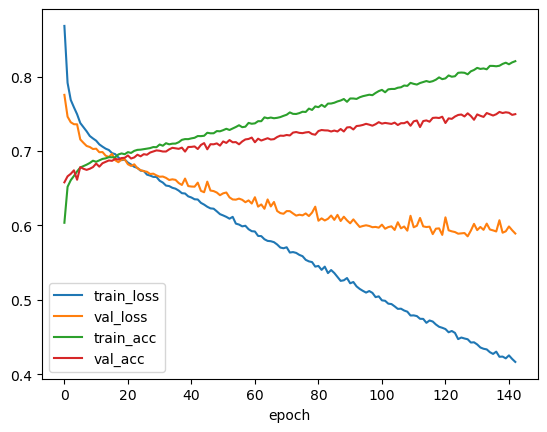

In [26]:
plt.figure()
plt.plot(history4.history["loss"], label = "train_loss")
plt.plot(history4.history["val_loss"], label = "val_loss")
plt.plot(history4.history["accuracy"], label = "train_acc")
plt.plot(history4.history["val_accuracy"], label = "val_acc")

plt.xlabel("epoch")
plt.legend()
plt.show()

In [27]:
score(y_test, y_pred4)

accuracy_score :  0.7557217818466004 
f1_score :  0.7524081674298545 
recall_score : 0.7557217818466004 
precision_score :  0.752579301210474


# Model5

- Dropout : 0.5

In [42]:
model5 = Sequential()
model5.add(Conv1D(filters = 64, kernel_size = 3, activation = "relu", padding = "same", input_shape = (951, 1)))
model5.add(keras.layers.MaxPooling1D(3))
model5.add(Dropout(0.5))
model5.add(Conv1D(filters = 64, kernel_size = 3, activation = "relu", padding = "same"))
model5.add(keras.layers.MaxPooling1D(3))
model5.add(Dropout(0.5))
model5.add(keras.layers.Flatten())
model5.add(Dense(64, activation = "relu"))
model5.add(Dense(32, activation = "relu"))
model5.add(Dropout(0.5))
model5.add(Dense(4, activation = "softmax"))

In [43]:
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 951, 64)           256       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 317, 64)          0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 317, 64)           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 317, 64)           12352     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 105, 64)          0         
 g1D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 105, 64)          

In [44]:
adam = keras.optimizers.Adam(learning_rate = 0.0001)
checkpoint = keras.callbacks.ModelCheckpoint("./model/classifier_best_model5.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True)
model5.compile(loss = "sparse_categorical_crossentropy", optimizer = adam, metrics = "accuracy")
history5 = model5.fit(scaled_train, y_train, epochs = 1000, validation_split = 0.2, batch_size = 64, 
                    callbacks = [early_stopping_cb, checkpoint])

Epoch 1/1000
504/504 [==============================] - 49s 95ms/step - loss: 0.9361 - accuracy: 0.5705 - val_loss: 0.8348 - val_accuracy: 0.6328
Epoch 2/1000
504/504 [==============================] - 48s 96ms/step - loss: 0.8428 - accuracy: 0.6291 - val_loss: 0.7808 - val_accuracy: 0.6522
Epoch 3/1000
504/504 [==============================] - 48s 96ms/step - loss: 0.8128 - accuracy: 0.6460 - val_loss: 0.7596 - val_accuracy: 0.6586
Epoch 4/1000
504/504 [==============================] - 49s 96ms/step - loss: 0.7978 - accuracy: 0.6535 - val_loss: 0.7621 - val_accuracy: 0.6550
Epoch 5/1000
504/504 [==============================] - 48s 96ms/step - loss: 0.7864 - accuracy: 0.6598 - val_loss: 0.7502 - val_accuracy: 0.6626
Epoch 6/1000
504/504 [==============================] - 49s 97ms/step - loss: 0.7814 - accuracy: 0.6629 - val_loss: 0.7436 - val_accuracy: 0.6638
Epoch 7/1000
504/504 [==============================] - 49s 97ms/step - loss: 0.7729 - accuracy: 0.6642 - val_loss: 0.7465 -

Epoch 57/1000
504/504 [==============================] - 48s 96ms/step - loss: 0.6772 - accuracy: 0.7016 - val_loss: 0.6723 - val_accuracy: 0.6995
Epoch 58/1000
504/504 [==============================] - 48s 96ms/step - loss: 0.6769 - accuracy: 0.7028 - val_loss: 0.6730 - val_accuracy: 0.6973
Epoch 59/1000
504/504 [==============================] - 49s 96ms/step - loss: 0.6784 - accuracy: 0.7043 - val_loss: 0.6707 - val_accuracy: 0.6997
Epoch 60/1000
504/504 [==============================] - 49s 97ms/step - loss: 0.6778 - accuracy: 0.7020 - val_loss: 0.6711 - val_accuracy: 0.7007
Epoch 61/1000
504/504 [==============================] - 49s 97ms/step - loss: 0.6733 - accuracy: 0.7052 - val_loss: 0.6701 - val_accuracy: 0.7004
Epoch 62/1000
504/504 [==============================] - 49s 97ms/step - loss: 0.6721 - accuracy: 0.7082 - val_loss: 0.6774 - val_accuracy: 0.6922
Epoch 63/1000
504/504 [==============================] - 49s 97ms/step - loss: 0.6713 - accuracy: 0.7054 - val_loss: 0

504/504 [==============================] - 48s 96ms/step - loss: 0.5421 - accuracy: 0.7637 - val_loss: 0.5986 - val_accuracy: 0.7351
Epoch 168/1000
504/504 [==============================] - 48s 96ms/step - loss: 0.5411 - accuracy: 0.7626 - val_loss: 0.5961 - val_accuracy: 0.7334
Epoch 169/1000
504/504 [==============================] - 48s 96ms/step - loss: 0.5374 - accuracy: 0.7629 - val_loss: 0.5940 - val_accuracy: 0.7350
Epoch 170/1000
504/504 [==============================] - 48s 96ms/step - loss: 0.5378 - accuracy: 0.7643 - val_loss: 0.5951 - val_accuracy: 0.7344
Epoch 171/1000
504/504 [==============================] - 48s 96ms/step - loss: 0.5398 - accuracy: 0.7616 - val_loss: 0.5938 - val_accuracy: 0.7375
Epoch 172/1000
504/504 [==============================] - 48s 96ms/step - loss: 0.5368 - accuracy: 0.7635 - val_loss: 0.5961 - val_accuracy: 0.7355
Epoch 173/1000
504/504 [==============================] - 48s 96ms/step - loss: 0.5390 - accuracy: 0.7607 - val_loss: 0.5964 - 

In [45]:
model5.evaluate(scaled_test, y_test)

840/840 [==============================] - 10s 11ms/step - loss: 0.5662 - accuracy: 0.7517


[0.566154420375824, 0.751702606678009]

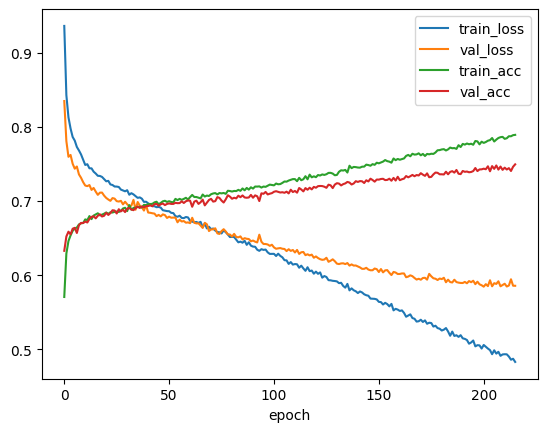

In [46]:
plt.figure()
plt.plot(history5.history["loss"], label = "train_loss")
plt.plot(history5.history["val_loss"], label = "val_loss")
plt.plot(history5.history["accuracy"], label = "train_acc")
plt.plot(history5.history["val_accuracy"], label = "val_acc")

plt.xlabel("epoch")
plt.legend()
plt.show()

In [47]:
y_pred5 = model5.predict(scaled_test)

840/840 [==============================] - 8s 10ms/step


In [48]:
score(y_test, y_pred5)

accuracy_score :  0.7517025789885006 
f1_score :  0.7472041280430216 
recall_score : 0.7517025789885006 
precision_score :  0.7486481538391457


# Robust Scaler

- MinMaxScaler 대신 RobustScaler 사용

In [10]:
rb = RobustScaler()

In [11]:
scaled_train = rb.fit_transform(x_train)
scaled_test = rb.transform(x_test)

In [12]:
scaled_train.shape, scaled_test.shape

((40305, 951), (26871, 951))

In [13]:
scaled_train = scaled_train.reshape(-1, 951, 1)
scaled_test = scaled_test.reshape(-1, 951, 1)

## Model Accuracy 확인

In [3]:
model = keras.models.load_model("./model/classifier_best_model.h5")
model2 = keras.models.load_model("./model/classifier_best_model2.h5")
model3 = keras.models.load_model("./model/classifier_best_model3.h5")
model4 = keras.models.load_model("./model/classifier_best_model4.h5")
model5 = keras.models.load_model("./model/classifier_best_model5.h5")

In [28]:
y_pred = model.predict(scaled_test)
y_pred2 = model2.predict(scaled_test)
y_pred3 = model3.predict(scaled_test)
y_pred4 = model4.predict(scaled_test)
y_pred5 = model5.predict(scaled_test)

840/840 [==============================] - 12s 15ms/step


In [30]:
print("Model1 : ", accuracy_score(y_test, np.argmax(y_pred, axis=1)))
print("Model2 : ", accuracy_score(y_test, np.argmax(y_pred2, axis=1)))
print("Model3 : ", accuracy_score(y_test, np.argmax(y_pred3, axis=1)))
print("Model4 : ", accuracy_score(y_test, np.argmax(y_pred4, axis=1)))
print("Model5 : ", accuracy_score(y_test, np.argmax(y_pred5, axis=1)))

Model1 :  0.7645416992296528
Model2 :  0.7009043206430725
Model3 :  0.771128726135983
Model4 :  0.7557217818466004
Model5 :  0.7517025789885006
